In [1]:
import os
from pathlib import Path
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))

import torch
from models.ddpm import *
from models.unet import Unet
from models.ddpm_classifier_free import Unet as Unet_class
from utils.image_utils import save_image_to_dir, save_patches_to_dir
from utils.model_utils import (load_model, load_classifier_free_model, generate_whole_image, 
                                   create_lcl_ctx_channels, create_inputs, generate_patches, stitch_patches,
                                   create_patch_channels)
from config import OVERLAP

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

artifact_dir = './artifacts/vindr_cvpr_mass_real:v322'
whole_img_model_path = f'{artifact_dir}/model_83999.pt'
# whole_image_model = load_classifier_free_model(whole_img_model_path, channels=1, num_classes=3)
whole_image_model = load_model(whole_img_model_path, channels=1)

# # load model for generating local contexts (mid-resolution images)
artifact_dir = './artifacts/vindr_cond_lcl_ctx:v131'
local_context_model_path = f'{artifact_dir}/model_110000.pt'
local_context_model = load_classifier_free_model(local_context_model_path, channels=3, num_classes=2)

artifact_dir = './artifacts/vindr_cond_patch:v90'
patch_model_path = f'{artifact_dir}/model_134000.pt'
patch_model = load_classifier_free_model(patch_model_path, channels=3, num_classes=2)

sampling loop time step: 100%|██████████| 150/150 [00:07<00:00, 20.84it/s]
/home/milica.skipina.ivi/projects/test_git/mambo/src/utils/image_utils.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  save_image(torch.tensor(image), img_path)


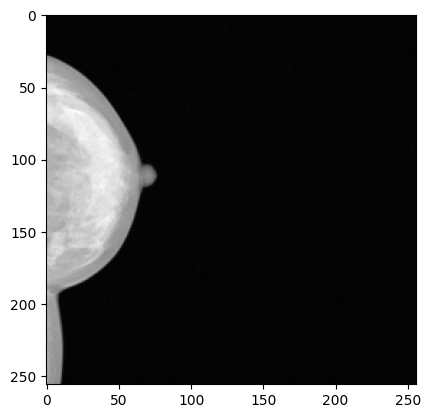

In [3]:
img = generate_whole_image(whole_image_model, device, batch_size=1, img_class='')
save_dir = '/lustre/seed/vindr_mass/0'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_image_to_dir(img, f'{save_dir}/whole_small.png')
plt.imshow(img[0], 'gray')

In [5]:
img_channels, patch_coords = create_lcl_ctx_channels(img, overlap=OVERLAP)
print(len(img_channels))
inputs, black_idx = create_inputs(img, img_channels, patch_coords, mask_shape=1024)
print(len(inputs), len(black_idx))
local_contexts = generate_patches(local_context_model, inputs, black_idx, total_timesteps=timesteps, sampling_timesteps=150, eta=1.0, overlap=OVERLAP, device=device, cond_idx=1)

25
25 18


sampling loop time step: 100%|██████████| 150/150 [00:17<00:00,  8.75it/s]


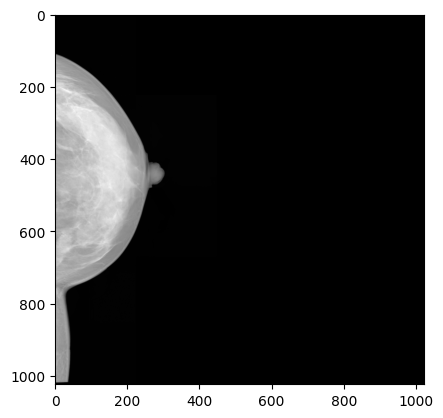

In [6]:
mid_img = stitch_patches(local_contexts, overlap=OVERLAP, final_shape=1024)
plt.imshow(mid_img, 'gray')

In [8]:
save_image_to_dir(mid_img, f'{save_dir}/whole_middle.png')
save_patches_to_dir(local_contexts,f'{save_dir}/local_contexts')

In [9]:
img_channels, patch_coords = create_patch_channels(torch.from_numpy(mid_img).unsqueeze(0), img, overlap=OVERLAP)
inputs, black_idx = create_inputs(img, img_channels, patch_coords, mask_shape=3072)
print(len(inputs), len(black_idx))

196 157


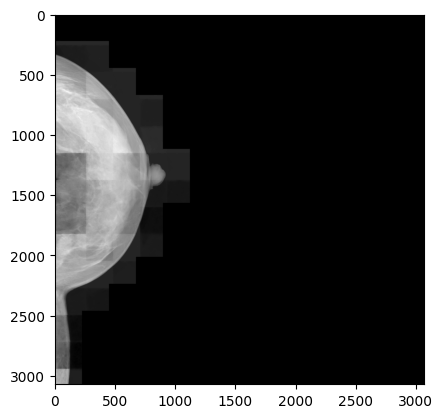

In [12]:
final_img = stitch_patches(patches, overlap=OVERLAP, final_shape=3072)
plt.imshow(final_img, 'gray')

In [10]:
patches = generate_patches(patch_model, inputs, black_idx, total_timesteps=timesteps, sampling_timesteps=150, eta=1.0, overlap=OVERLAP, device=device, cond_idx=1)
final_img = stitch_patches(patches, overlap=OVERLAP, final_shape=3072)
plt.imshow(final_img, 'gray')

sampling loop time step: 100%|██████████| 150/150 [00:19<00:00,  7.69it/s]


TypeError: stitch_patches() missing 1 required positional argument: 'final_shape'

In [ ]:
save_image_to_dir(final_img,  '../images/final_img.png')
save_patches_to_dir(patches, '../images/patches')